# **AIPI 590 - XAI | Explainable Techniques**
### Explainable Techniques (PDP, ICE, ALE)


Author: Lindsay Gross


Dataset: Lifestyle and Sleep Patterns - Health Patterns in Sleep


License: CC0: Public Domain 


Collaborators: Minahil Fatima (Owner)


Source: https://www.kaggle.com/datasets/minahilfatima12328/lifestyle-and-sleep-patterns?resource=download


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/explainable-techniques-II/blob/main/explainable-techniques-II.ipynb)




This notebook provides ...





In [39]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install PyALE


/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: No such file or directory
/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: exec: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: cannot execute: No such file or directory
/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: No such file or directory
/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: exec: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: cannot execute: No such file or directory
/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: No such file or directory
/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/pip: line 2: exec: /Users/lindsaygross/ME AIPI Classes/XAI/.venv/bin/python3: cannot execute: No such file or directory


In [40]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


# Models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

# ALE
%pip install PyALE
from PyALE import ale


# # XAI
# import shap
# from alepython import ale_plot
# from sklearn.inspection import PartialDependenceDisplay
# from sklearn.inspection import permutation_importance

# np.random.seed(1)

You should consider upgrading via the '/Users/lindsaygross/ME AIPI Code/XAI/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Dataset
We are using the **Lifestyle and Sleep Health dataset**, which contains 374 rows and 13 columns.  
The dataset includes demographic, lifestyle, and health-related features such as:

- **Demographics:** Gender, Age, Occupation  
- **Lifestyle factors:** Sleep Duration, Physical Activity Level, Daily Steps  
- **Health indicators:** Stress Level, BMI Category, Blood Pressure, Heart Rate  
- **Targets/outcomes:** Quality of Sleep (numeric), Sleep Disorder (categorical)  

For modeling, we focus on **Quality of Sleep** as the target variable.


In [41]:
# Load Data 
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [42]:
# Show first 5 rows
df.head()  

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [43]:
# Info about columns & data types
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [44]:
# get null values
df.isnull().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

**Dataset**
We will use the classic [UCI adult income dataset](https://archive.ics.uci.edu/dataset/2/adult). This is a classification task to predict if people made over $50k in the 1990's.

**Model**
We will train an XGBoost classifier model with default parameters for explanatory purposes. We are also performing a 50-50 train/test split for optimization purposes.

In [45]:
# Clean data

# Drop ID column (not useful for modeling)
if "Person ID" in df.columns:
    df = df.drop(columns=["Person ID"])

# Split Blood Pressure into numeric systolic/diastolic
if "Blood Pressure" in df.columns:
    bp_split = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic_BP"] = pd.to_numeric(bp_split[0], errors="coerce")
    df["Diastolic_BP"] = pd.to_numeric(bp_split[1], errors="coerce")
    df = df.drop(columns=["Blood Pressure"])

# Quick check
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           155 non-null    object 
 11  Systolic_BP              374 non-null    int64  
 12  Diastolic_BP             374 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB
None
  Gender  Age    

## Data Cleaning
- Dropped the `Person ID` column (not useful for modeling).  
- Split `Blood Pressure` into **Systolic_BP** and **Diastolic_BP** for numeric analysis.  
- Encoded categorical variables (`Gender`, `Occupation`, `BMI Category`, `Sleep Disorder`) using label encoding.  



In [ ]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Copy dataset to keep a clean version
df_model = df.copy()

# Identify categorical columns
cat_cols = df_model.select_dtypes(include=["object"]).columns
print("Categorical columns:", cat_cols)

# Encode each categorical column
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    encoders[col] = le  # store encoder in case you need to decode later


print(df_model.info())
print(df_model.head())


Categorical columns: Index(['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    int64  
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    int64  
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    int64  
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           374 non-null    int64  
 11  Systolic_BP              374 non-null    int64  
 12  Diastolic_BP             374 no

## Encoding Categorical Variables

The dataset has several categorical features: **Gender, Occupation, BMI Category, and Sleep Disorder**.  
To prepare the data for modeling, these variables were encoded into numeric form using `LabelEncoder`.  

- Each category is now represented as an integer (e.g., Male = 1, Female = 0).  
- This ensures that all features are numeric and compatible with machine learning models.  
- The dataset now has **13 numeric columns** and is ready for model training.


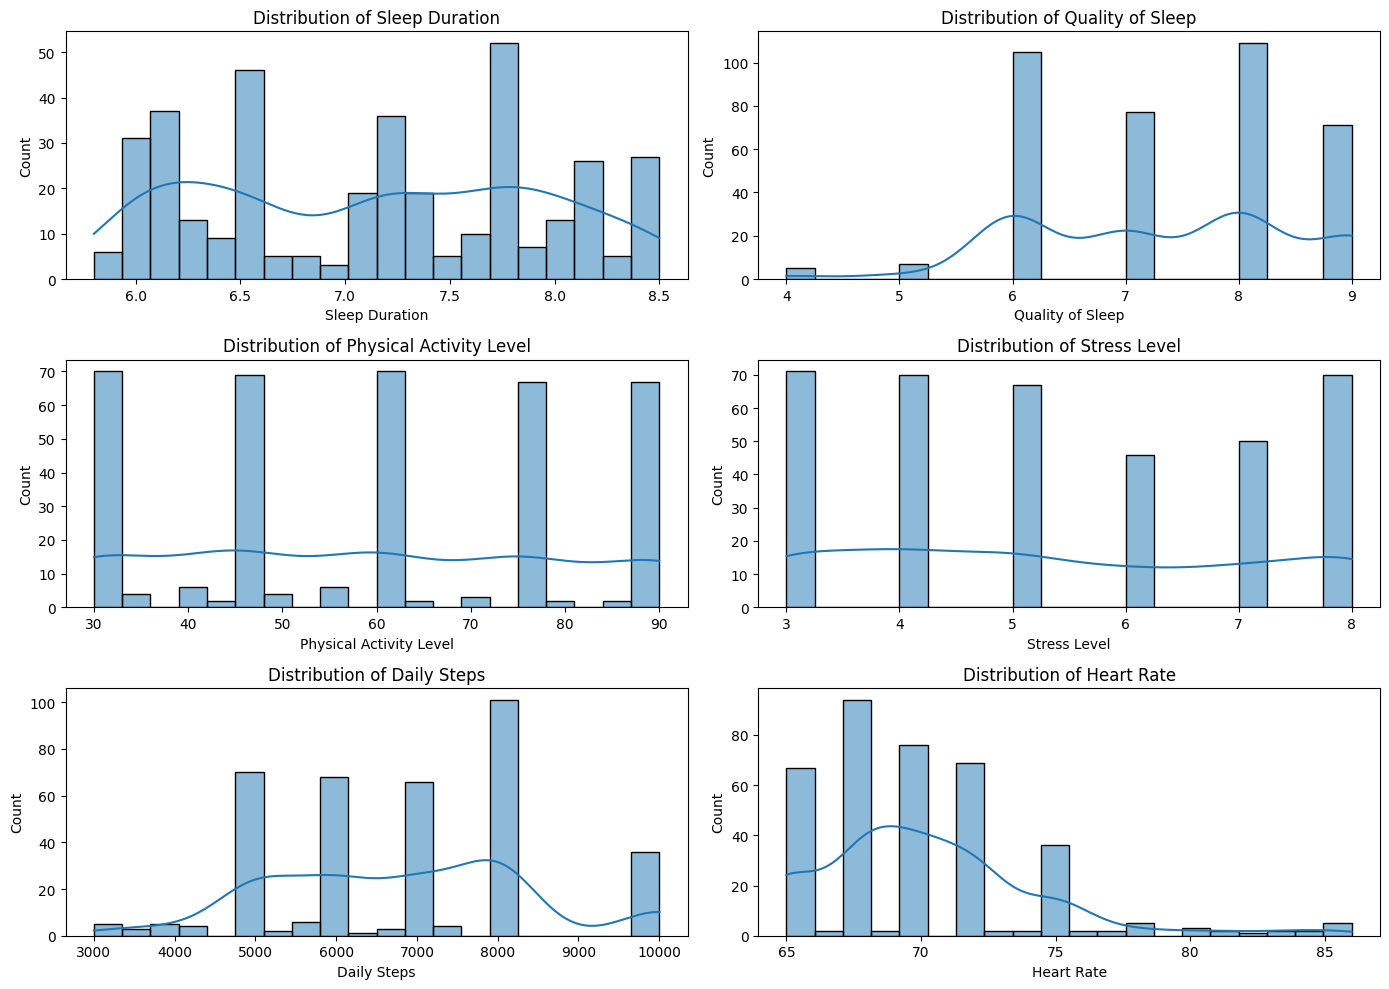

In [ ]:
# Exploratory Data Analysis


# Summary statistics
df.describe()

# Distribution plots for key numerical features
num_features = ["Sleep Duration", "Quality of Sleep", 
                "Physical Activity Level", "Stress Level", 
                "Daily Steps", "Heart Rate"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()



## Exploratory Data Analysis

We began with a descriptive analysis of the key numerical features in the dataset.  

- **Sleep Duration**: Most values fall between 6–8 hours, with a peak around 7 hours.  
- **Quality of Sleep**: Concentrated between 6–8, suggesting moderate to good sleep quality for most individuals.  
- **Physical Activity Level**: Shows variation across the population, with many clustered at mid to high activity levels.  
- **Stress Level**: Generally ranges from 3–8, with most people reporting moderate stress.  
- **Daily Steps**: Peaks around 5,000–8,000 steps, with a few very active individuals reaching 10,000.  
- **Heart Rate**: Centered around 65–75 bpm, with fewer individuals above 80.  

These distributions provide a baseline understanding of lifestyle and health indicators in the dataset and will guide further correlation and model-based analysis.


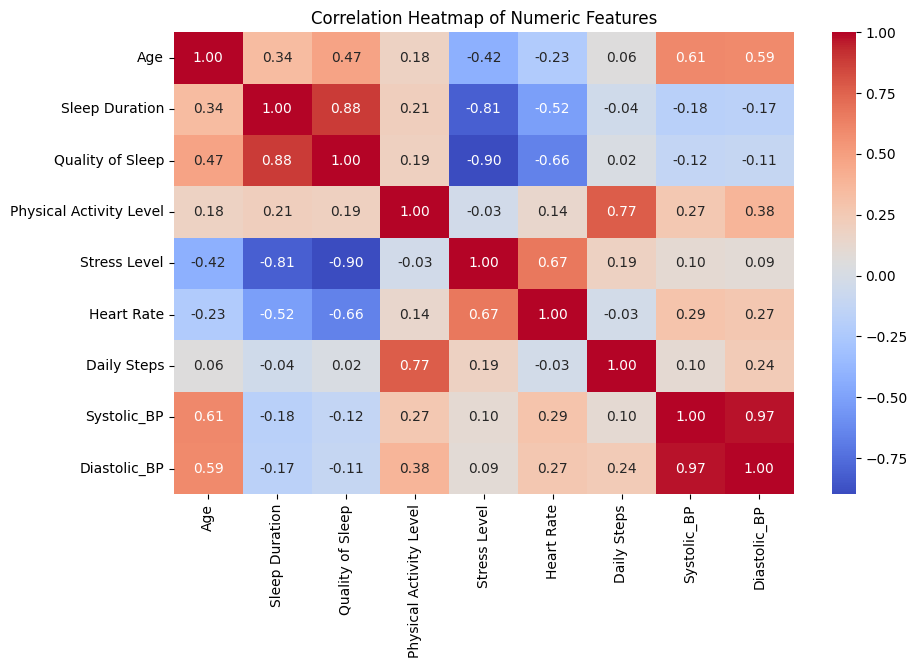

In [ ]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## Correlation Analysis

The correlation heatmap reveals several important relationships between features:

- **Sleep Duration ↔ Quality of Sleep**: Strong positive correlation (~0.88), suggesting longer sleep is associated with better quality.  
- **Stress Level ↔ Quality of Sleep**: Strong negative correlation (~-0.90), indicating higher stress reduces sleep quality.  
- **Stress Level ↔ Sleep Duration**: Negative correlation (~-0.81), showing stressed individuals tend to sleep less.  
- **Daily Steps ↔ Physical Activity Level**: Positive correlation (~0.77), as expected since both measure activity.  
- **Age ↔ Blood Pressure (Systolic/Diastolic)**: Moderate positive correlations, aligning with known health trends.  

These findings suggest that correlations between features could bias PDP plots, making **ALE plots** especially useful to adjust for these dependencies.


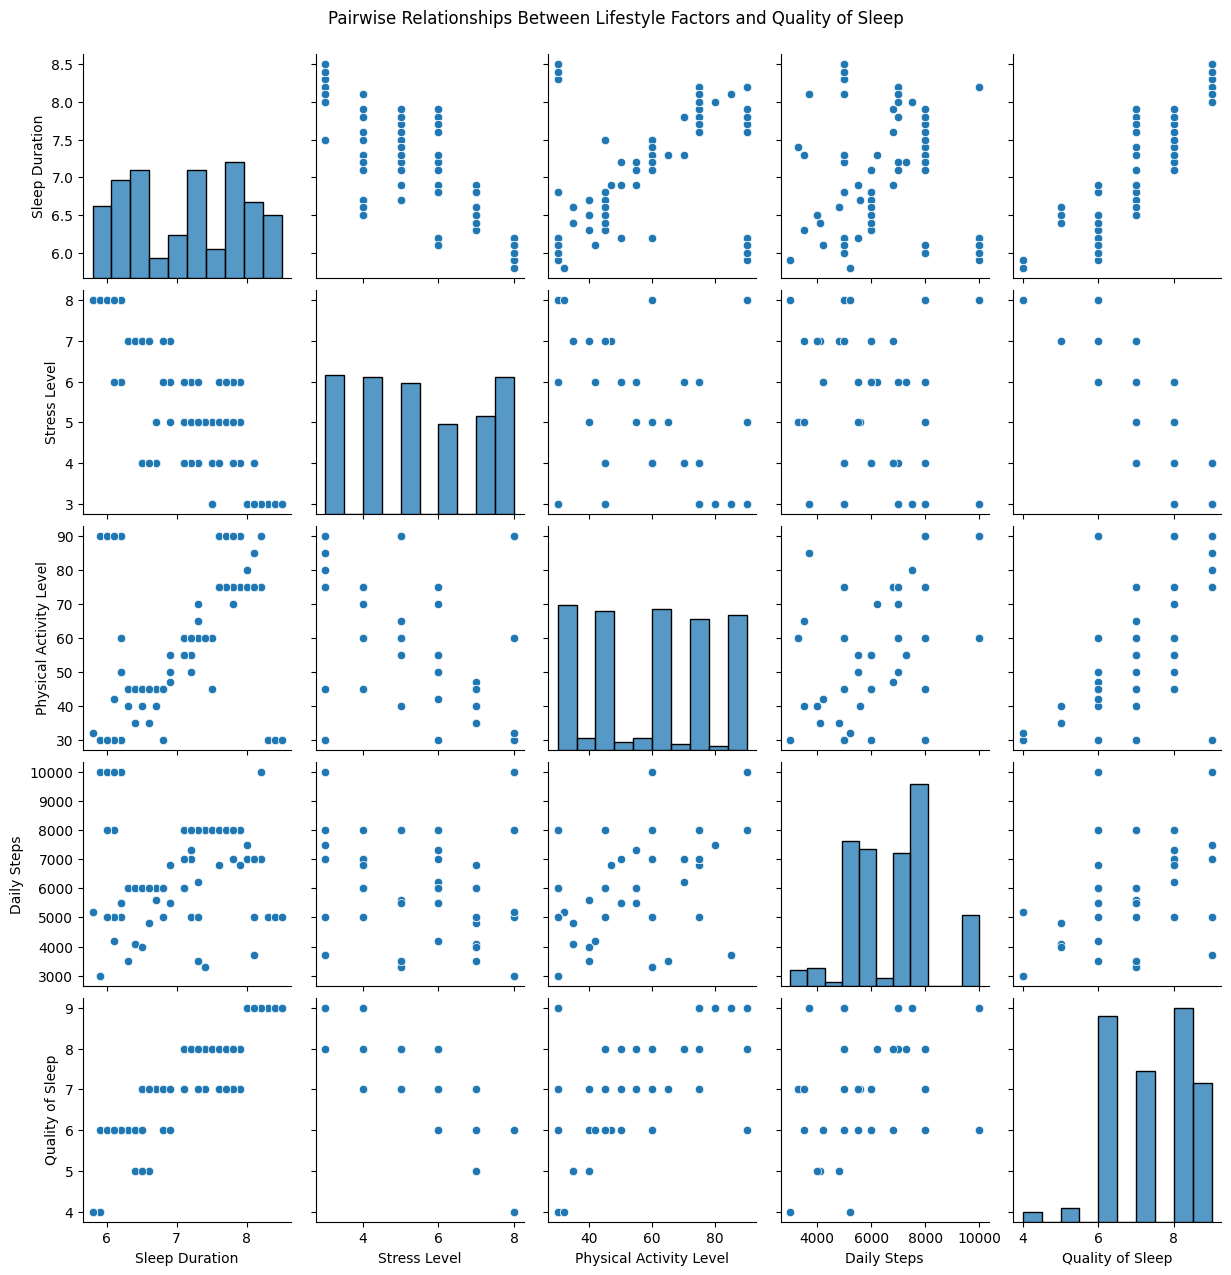

In [ ]:

# Pairwise scatterplots for selected features vs Quality of Sleep
num_cols_for_pairplot = ["Sleep Duration", "Stress Level", 
                         "Physical Activity Level", "Daily Steps", 
                         "Quality of Sleep"]

sns.pairplot(df[num_cols_for_pairplot], diag_kind="hist")
plt.suptitle("Pairwise Relationships Between Lifestyle Factors and Quality of Sleep", y=1.02)
plt.show()

## Pairwise Feature Relationships

The pairplot highlights relationships between key lifestyle factors and **Quality of Sleep**:

- **Sleep Duration vs Quality of Sleep**: Clear positive trend — individuals who sleep longer tend to report higher quality.  
- **Stress Level vs Quality of Sleep**: Strong negative trend — higher stress is associated with poorer sleep quality.  
- **Physical Activity vs Daily Steps**: Positive correlation, confirming both capture related aspects of activity.  
- **Activity/Steps vs Quality of Sleep**: Weak to moderate positive relationships, suggesting more active individuals may have better sleep.  

These scatterplots reinforce the correlation findings and illustrate how lifestyle factors interact with sleep outcomes, setting the stage for PDP, ICE, and ALE analysis.


In [54]:
# Model Training and Evaluation


# Define target and features 
target = "Quality of Sleep"
X = df_model.drop(columns=[target])
y = df_model[target]

#  Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model using Random Forest 
model = RandomForestRegressor(random_state=42, n_estimators=200)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 0.13
R²: 0.99


## Model Training and Evaluation

We trained a **Random Forest Regressor** using 80/20 train-test split, with **Quality of Sleep** as the target variable.  

- The model achieved **RMSE = 0.13** and **R² = 0.99**, indicating very strong predictive performance.  
- Random Forest was chosen because it can handle non-linear relationships and interactions between features, which are important for lifestyle and health data.  

This trained model will be used to generate **PDP, ICE, and ALE plots** to better understand how individual features influence sleep quality.


## Partial Dependence Plots (PDP) 📈

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model [Paper, 2001](https://jerryfriedman.su.domains/ftp/trebst.pdf)

**How it Works:**
1. Select feature of interest
2. For every instance in training dataset:
* Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
* Make predictions with the black box model for newly created instances
* You now have a set of points for an instance with the feature value from the grid and the respective predictions
3. Average across all instances and plot

Here we will show both a built-in library implementation, [scikit learn's Partial Dependence Display](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html) and we will build our own implementation in numpy.


/Users/lindsaygross/ME AIPI Code/XAI/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/lindsaygross/ME AIPI Code/XAI/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


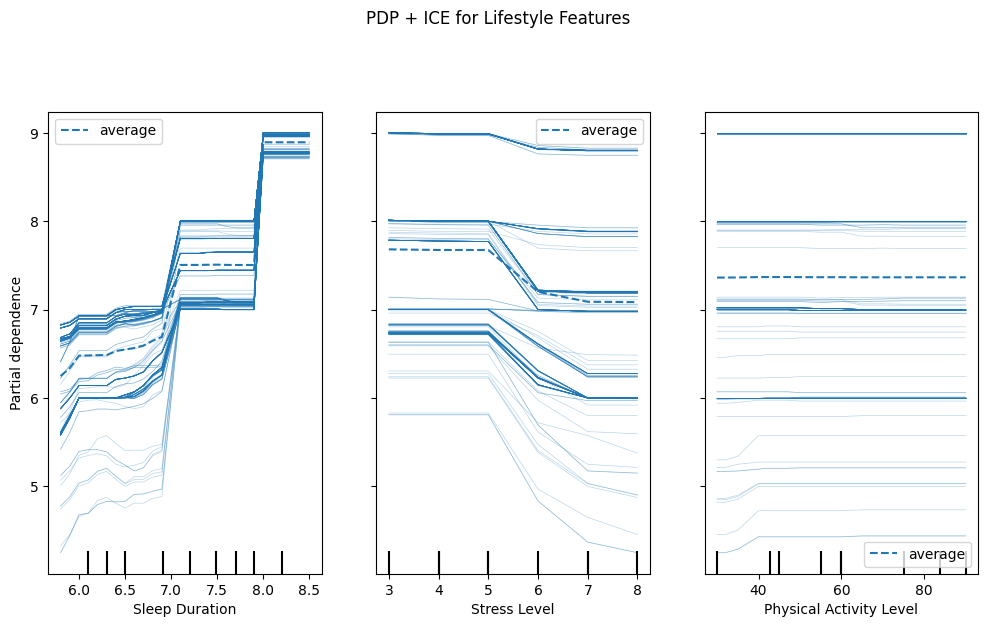

In [55]:
# Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots


# Pick features to analyze
features_to_plot = ["Sleep Duration", "Stress Level", "Physical Activity Level"]

# Plot PDP + ICE
fig, ax = plt.subplots(figsize=(12, 6))
# use partial dependence display to plot both PDP and ICE
PartialDependenceDisplay.from_estimator(
    model, X_train, features_to_plot, kind="both", ax=ax
)
plt.suptitle("PDP + ICE for Lifestyle Features", y=1.05)
plt.show()


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


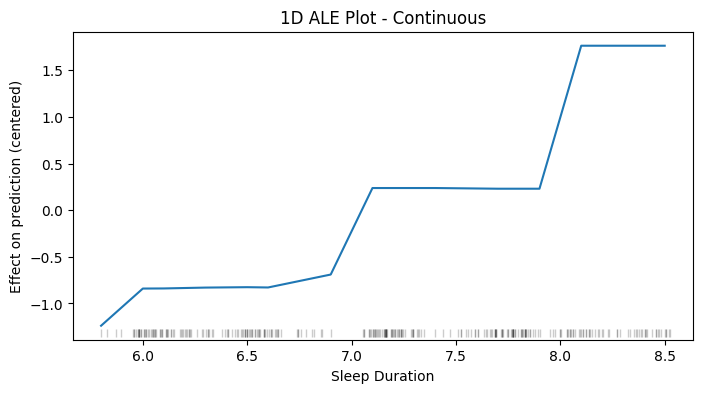

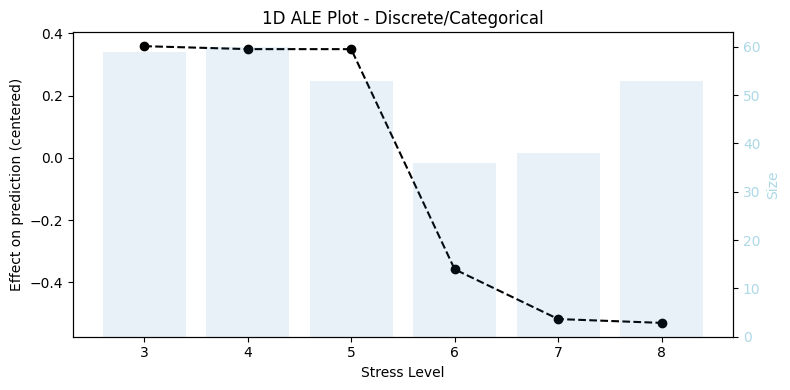

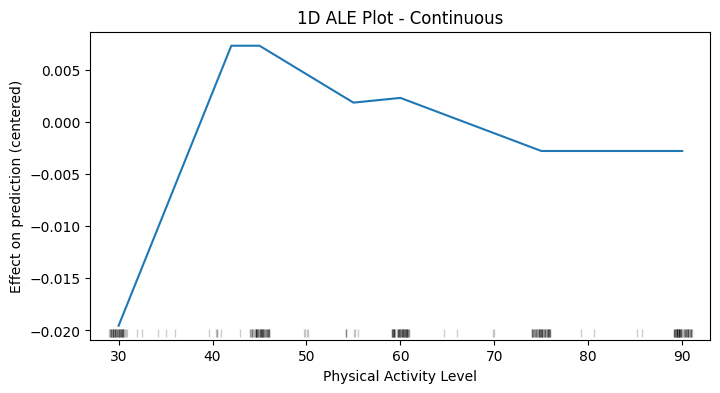

In [56]:

# ALE for Sleep Duration
ale_plot1 = ale(
    X=X_train, model=model, feature=["Sleep Duration"],
    grid_size=20, include_CI=False
)

# ALE for Stress Level
ale_plot2 = ale(
    X=X_train, model=model, feature=["Stress Level"],
    grid_size=20, include_CI=False
)

# ALE for Physical Activity Level
ale_plot3 = ale(
    X=X_train, model=model, feature=["Physical Activity Level"],
    grid_size=20, include_CI=False
)
